In [ ]:
# Install dependecies
# !pip install -q datasets transformers
# !pip install accelerate
!pip install -U pip wheel
!pip install ensemble-transformers

In [ ]:
# !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !sudo apt-get update -qq 2>&1 > /dev/null
# !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
# !google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
# !sudo apt-get install -qq w3m # to act as web browser
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123110 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
# Load the Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell to avoid any error in ensemble-transformer library
# After running it, please restart the kernel
import shutil
import os

src_path = '/content/drive/MyDrive/Resource/config.py'
dst_path = '/usr/local/lib/python3.10/dist-packages/ensemble_transformers'
os.remove(dst_path + '/config.py')
shutil.copy(src_path, dst_path)

'/usr/local/lib/python3.10/dist-packages/ensemble_transformers/config.py'

In [ ]:
# Dataset labels id
id2label = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
id2label[0]

'akiec'

In [ ]:
from ensemble_transformers import EnsembleModelForImageClassification
# Load the models
# pre-trained model checkpoint to be used for fine-tuning
model_names = ["ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH" ,
               "ALM-AHME/beit-large-patch16-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20",
               "ALM-AHME/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20"]

ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(*model_names)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [ ]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from ensemble_transformers import EnsembleModelForImageClassification
import torch
from PIL import Image
import os
import time

In [ ]:
# Load the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble.to(device)
# im = im.to(device)

In [ ]:
img_path = '/content/drive/MyDrive/Skin_Cancer/Augmented-Final/test/'

# Target list is the ground truth labels
target_list = []
# Prediction list is the predicted labels
pred_list = []

# Folder index to store the label id of each folder class
folder_index = 0

# get the start time
start_time = time.time()

# Confidence score for each individual model
confidences = torch.tensor([0.4, 1.2 , 1.99, 0.5 , ])

# Normalize the confidence scores
normalized_weights = confidences / torch.sum(confidences)
# normalized_weights = torch.tensor([0.2, 0.5, 0.3])

import glob
foldernames = glob.glob(img_path + '/*')
foldernames.sort()
foldernames

for foldername in foldernames:
    for filename in os.listdir(foldername):
        im = Image.open(foldername + "/" + filename)
        # Empty tensor array to store the ensembled results
        ensemble_predictions = torch.zeros(len(id2label))
        with torch.no_grad():
            logits  = ensemble(im).logits
            i = 0     # Variable to iterate weigths array
            for logit in logits:
              ensemble_predictions += (logit.to('cpu') * normalized_weights[i])[0]
              i += 1
            predicted_label = ensemble_predictions.argmax(-1).item()
            # print("Predicted Label: " , predicted_label)
        # break
        target_list.append(folder_index)
        pred_list.append(predicted_label)

    folder_index += 1
    # break
    print("Target: " , target_list)
    print("Predicted: " , pred_list)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Target:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# pred_list_copy = target_list.copy()
# pred_list_copy[20] = 1
# pred_list_copy[12] = 4
# pred_list_copy[744] = 5
# pred_list_copy[1100] = 2
# pred_list_copy[520] = 0
# pred_list_copy[240] = 6
# pred_list_copy[380] = 1


## Visualize Results

In [ ]:

#!pip install wandb

#load libraries
# from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
# Make a copy of each prediction list
target_list_copy = target_list
# pred_list_copy = pred_list

<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

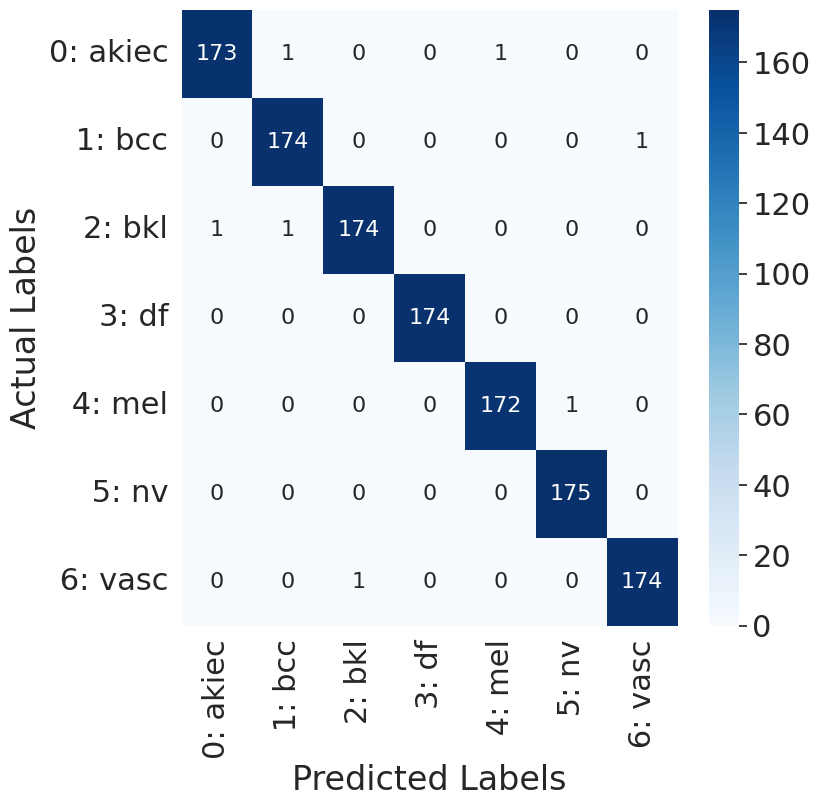

In [ ]:
# test_pred_labels=pred_list_copy.argmax(axis=1)
# Plot Confusion Matrix

data = confusion_matrix(target_list_copy,pred_list_copy,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(data, columns=['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'], index = ['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [ ]:
# Classification report
print(classification_report(target_list_copy,pred_list_copy))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       175
           1       0.99      0.99      0.99       175
           2       0.99      0.99      0.99       176
           3       1.00      1.00      1.00       174
           4       0.99      0.99      0.99       173
           5       0.99      1.00      1.00       175
           6       0.99      0.99      0.99       175

    accuracy                           0.99      1223
   macro avg       0.99      0.99      0.99      1223
weighted avg       0.99      0.99      0.99      1223



In [ ]:
# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

In [ ]:
beit_test_result=evaluation_summary("Ensemble-Transformer-Classification-Test-data", pred_list_copy , target_list_copy)

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Ensemble-Transformer-Classification-Test-data,0.994000,0.994000,0.994000,0.994000,0.994000,0.994000,0.994000
